In [1]:
from torch import nn
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from core.data.dataset import SlidingWindowDataset
from torch.utils.data import DataLoader

In [2]:
class MLPTradingBaseline(nn.Module):
    def __init__(self, input_dim, look_ahead):
        super().__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, look_ahead)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [3]:
df = pd.read_csv('../../data/raw/BTCUSDT.csv', sep='|', header=None, usecols=[0, 1, 2, 3, 4, 5], 
                 names=['timestemp', 'open', 'high', 'low', 'close', 'volume'], nrows=1000)
df['timestemp'] = pd.to_datetime(df['timestemp'], unit='s')

tensor_data = torch.tensor(df.set_index('timestemp').sort_index().values, dtype=torch.float32)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
look_back = 10
look_ahead = 4
features_count = 5
batch_size = 32

dataset = SlidingWindowDataset(tensor_data, look_back=look_back, look_ahead=look_ahead, 
                                 input_indices=range(features_count), target_indices=[3])

sequences = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [6]:
model = MLPTradingBaseline(look_back*features_count, look_ahead).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-10)

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x, y in sequences:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).unsqueeze(dim=-1)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'epoch: {epoch}, loss: {epoch_loss/len(dataset)}')
      

epoch: 0, loss: 429002.5481256332
epoch: 1, loss: 281387.29989868286
epoch: 2, loss: 155684.74924012157
epoch: 3, loss: 66224.53584093212
epoch: 4, loss: 21774.569718844985
epoch: 5, loss: 6202.643901975684
epoch: 6, loss: 1773.4717855559777
epoch: 7, loss: 580.861091652419
epoch: 8, loss: 229.12196543344731
epoch: 9, loss: 105.8384627600209
epoch: 10, loss: 55.209426400630065
epoch: 11, loss: 32.2641043774142
epoch: 12, loss: 21.336487805831275
epoch: 13, loss: 16.01043693441992
epoch: 14, loss: 13.384831081649333
epoch: 15, loss: 12.082334671097806
epoch: 16, loss: 11.433066150700068
epoch: 17, loss: 11.107466727646168
epoch: 18, loss: 10.942930038939132
epoch: 19, loss: 10.858627089613476


In [7]:
y_close_pred = []
model.eval()
with torch.no_grad():
    for x, y in sequences:
        x = x.to(device)
        y_pred = model(x)
        y_close_pred.append(y_pred[:, 0].cpu())
    y_close_pred = torch.cat(y_close_pred, dim=0)

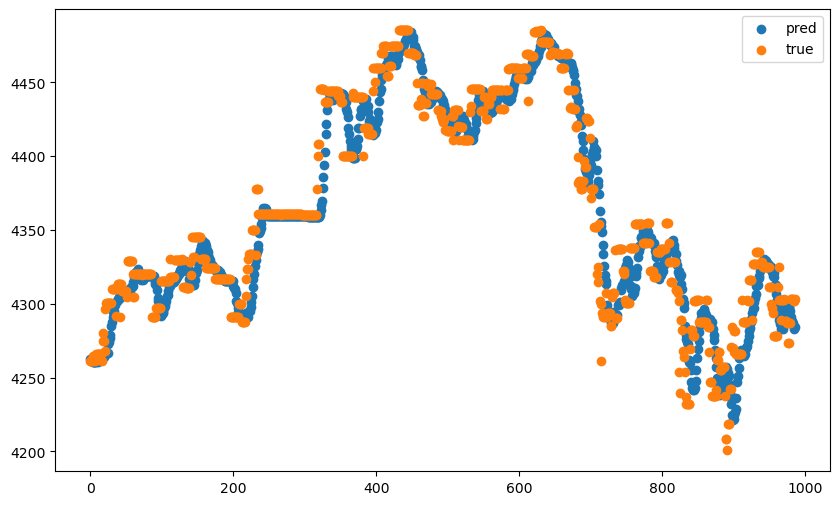

In [8]:
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.scatter(x = range(len(y_close_pred)), y = y_close_pred, label='pred')
plt.scatter(x = range(len(y_close_pred)), y = df['close'].values[-len(y_close_pred):], label='true')
# plt.xlim(700, 1000); 
plt.legend();

# Part 2

In [9]:
class SimpleLinearBaseline(nn.Module):
    def __init__(self, input_dim, look_ahead):
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_dim, look_ahead)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [10]:
model = SimpleLinearBaseline(features_count*look_back, look_ahead).to(device)
criterion = lambda y_hat, y, l=0.1: torch.mean((y_hat - y) ** 2) + (l/2) * torch.norm(model.fc.weight)**2
optimizer = torch.optim.SGD(model.parameters(), lr=1e-9)

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x, y in sequences:
        x, y = x.to(device), y.to(device)
        y_pred = model(x).unsqueeze(dim=-1)
        loss = criterion(y_pred, y, l=0.05)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'epoch: {epoch}, loss:{epoch_loss/len(dataset)}')

epoch: 0, loss:51065.467268251
epoch: 1, loss:12.715189350170688
epoch: 2, loss:12.714816402640144
epoch: 3, loss:12.714415528974754
epoch: 4, loss:12.714040559113569
epoch: 5, loss:12.713622828505805
epoch: 6, loss:12.713291535382334
epoch: 7, loss:12.7129207212995
epoch: 8, loss:12.712510547618615
epoch: 9, loss:12.712144256483578


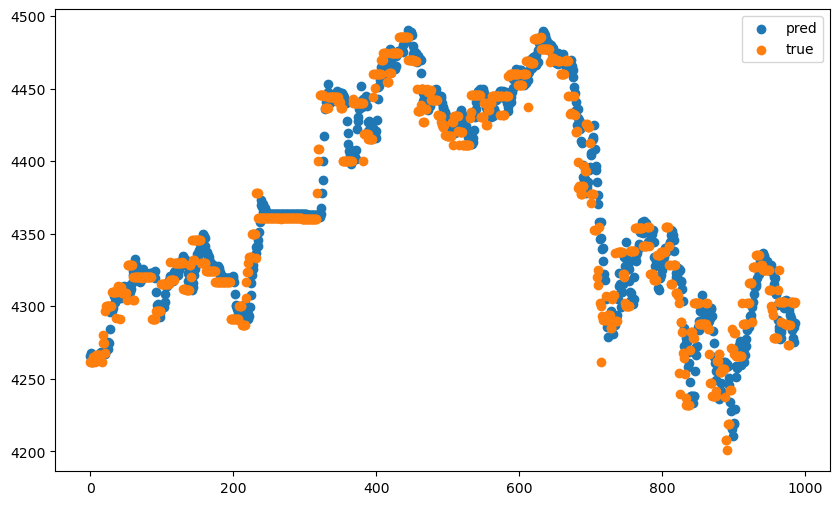

In [11]:
y_close_pred = []
model.eval()
with torch.no_grad():
    for x, y in sequences:
        x = x.to(device)
        y_pred = model(x)
        y_close_pred.append(y_pred[:, 0].cpu())
    y_close_pred = torch.cat(y_close_pred, dim=0)

plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.scatter(x = range(len(y_close_pred)), y = y_close_pred, label='pred')
plt.scatter(x = range(len(y_close_pred)), y = df['close'].values[-len(y_close_pred):], label='true')
# plt.xlim(700, 1000); 
plt.legend();

In [12]:
class SimpleLinearBaseline(nn.Module):
    def __init__(self, input_dim, look_ahead):
        super().__init__()

        self.flatten = nn.Flatten()
        self.w = nn.Parameter(torch.randn(input_dim, look_ahead) * 0.1)
        self.b = nn.Parameter(torch.zeros(1, look_ahead))

    def forward(self, x):
        x = self.flatten(x)
        x = x @ self.w + self.b
        return x

In [13]:
model = SimpleLinearBaseline(features_count*look_back, look_ahead).to(device)
criterion = lambda y_hat, y, l=0.1: torch.mean((y_hat - y) ** 2) + (l/2) * torch.norm(model.w)**2
optimizer = torch.optim.SGD(model.parameters(), lr=1e-9)

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x, y in sequences:
        x, y = x.to(device), y.to(device)
        y_pred = model(x).unsqueeze(dim=-1)
        loss = criterion(y_pred, y, l=0.05)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'epoch: {epoch}, loss:{epoch_loss/len(dataset)}')

epoch: 0, loss:40675.457406056565
epoch: 1, loss:13.31211339763112
epoch: 2, loss:13.311624130821034
epoch: 3, loss:13.311184891813793
epoch: 4, loss:13.310701998292252
epoch: 5, loss:13.310245672378617
epoch: 6, loss:13.309785879612452
epoch: 7, loss:13.309326937133418
epoch: 8, loss:13.30886390168133
epoch: 9, loss:13.308403591013002


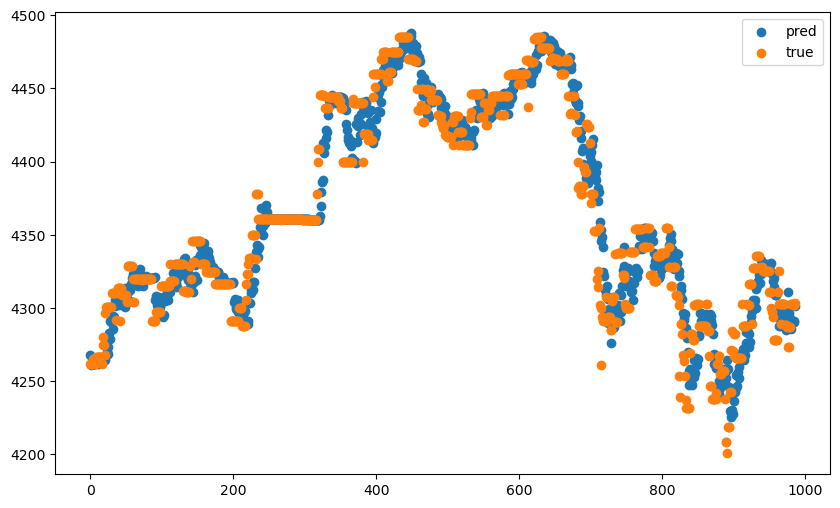

In [14]:
y_close_pred = []
model.eval()
with torch.no_grad():
    for x, y in sequences:
        x = x.to(device)
        y_pred = model(x)
        y_close_pred.append(y_pred[:, 0].cpu())
    y_close_pred = torch.cat(y_close_pred, dim=0)

plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.scatter(x = range(len(y_close_pred)), y = y_close_pred, label='pred')
plt.scatter(x = range(len(y_close_pred)), y = df['close'].values[-len(y_close_pred):], label='true')
# plt.xlim(700, 1000); 
plt.legend();